# Art Style Transfer

This notebook is an implementation of the algorithm described in "A Neural Algorithm of Artistic Style" (http://arxiv.org/abs/1508.06576) by Gatys, Ecker and Bethge. Additional details of their method are available at http://arxiv.org/abs/1505.07376 and https://bethgelab.org/deepneuralart/.

An image is generated which combines the content of a photograph with the "style" of a painting. This is accomplished by jointly minimizing the squared difference between feature activation maps of the photo and generated image, and the squared difference of feature correlation between painting and generated image. A total variation penalty is also applied to reduce high frequency noise. 

In [1]:
import lasagne
import numpy as np
import pickle
import skimage.transform
import scipy
import academictorrents as at

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX 580 (CNMeM is disabled, cuDNN not available)


In [3]:
# VGG-19, 19-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/3785162f95cd2d5fee77
# License: non-commercial use only

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

IMAGE_W = 600

# Note: tweaked to use average pooling instead of maxpooling
def build_model():
    net = {}
    net['input'] = InputLayer((1, 3, IMAGE_W, IMAGE_W))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2, mode='average_exc_pad')
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2, mode='average_exc_pad')
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2, mode='average_exc_pad')
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2, mode='average_exc_pad')
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2, mode='average_exc_pad')

    return net

In [ ]:
# Download the normalized pretrained weights from:
# https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl
# (original source: https://bethgelab.org/deepneuralart/)

#!wget -c https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl

filename = at.get("854efbd8e2c085e8e0e5fb2d254ed0e21da6008e")



In [5]:
# build VGG net and load weights

net = build_model()

values = pickle.load(open(filename))['param values']
lasagne.layers.set_all_param_values(net['pool5'], values)

In [6]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (IMAGE_W, w*IMAGE_W/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGE_W/w, IMAGE_W), preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_W//2:h//2+IMAGE_W//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

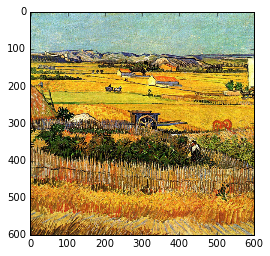

In [11]:
photo_filename = at.get("c8b687c984d3d902310f27d56759ed69f5e1b4a7","Paris (1886-88)/Self-Portrait 2.jpg")

photo = plt.imread(art_filename)
rawim, photo = prep_image(photo)
plt.imshow(rawim)

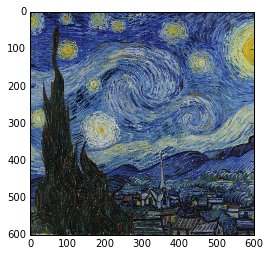

In [14]:
art_filename = at.get("c8b687c984d3d902310f27d56759ed69f5e1b4a7","Saint Remy (1889-90)/Starry Night.jpg")

art = plt.imread(art_filename)
rawim, art = prep_image(art)
plt.imshow(rawim)

In [15]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g


def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    
    loss = 1./2 * ((x - p)**2).sum()
    return loss


def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

In [16]:
layers = ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
layers = {k: net[k] for k in layers}

In [17]:
# Precompute layer activations for photo and artwork
input_im_theano = T.tensor4()
outputs = lasagne.layers.get_output(layers.values(), input_im_theano)

photo_features = {k: theano.shared(output.eval({input_im_theano: photo}))
                  for k, output in zip(layers.keys(), outputs)}
art_features = {k: theano.shared(output.eval({input_im_theano: art}))
                for k, output in zip(layers.keys(), outputs)}

In [18]:
# Get expressions for layer activations for generated image
generated_image = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

gen_features = lasagne.layers.get_output(layers.values(), generated_image)
gen_features = {k: v for k, v in zip(layers.keys(), gen_features)}

In [19]:
# Define loss function
losses = []

# content loss
losses.append(0.001 * content_loss(photo_features, gen_features, 'conv4_2'))

# style loss
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv1_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv2_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv3_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv4_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv5_1'))

# total variation penalty
losses.append(0.1e-7 * total_variation_loss(generated_image))

total_loss = sum(losses)

In [20]:
grad = T.grad(total_loss, generated_image)

In [ ]:
# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

In [ ]:
# Initialize with a noise image
generated_image.set_value(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

x0 = generated_image.get_value().astype('float64')
xs = []
xs.append(x0)

# Optimize, saving the result periodically
for i in range(8):
    print(i)
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)
    x0 = generated_image.get_value().astype('float64')
    xs.append(x0)

0


In [ ]:
def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)    
    plt.imshow(deprocess(xs[i]))
plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')